Creacion de dataframe para el modelo de ML usando el id_item

In [17]:
import pandas as pd
import json
import ast
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [18]:
def check_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [19]:
data = []
with open('../output_steam_games.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
df_steam = pd.DataFrame(data)
df_steam=df_steam.dropna(how='all')
columns=['url','reviews_url','specs','publisher','early_access']
df_steam=df_steam.drop(columns,axis=1).reset_index(drop=True)
df_steam=df_steam.dropna(subset=['id']).reset_index(drop=True)
df_steam=df_steam.dropna(subset=['developer']).reset_index(drop=True)
df_steam=df_steam.dropna(subset=['genres']).reset_index(drop=True)
df_steam['incluye_free'] = df_steam.apply(lambda row: 'si' if 'Free to Play' in row['genres'] else 'no', axis=1)
df_steam.loc[df_steam['incluye_free'] == 'si', 'price'] = 0.0
df_steam.loc[df_steam['incluye_free'] == 'si', 'genres'] = df_steam.loc[df_steam['incluye_free'] == 'si', 'genres'].apply(lambda x: [genre for genre in x if genre != 'Free to Play'])
df_steam=df_steam.drop('incluye_free',axis=1)
df_steam['is_float'] = df_steam['price'].apply(check_float)
condiciones = (df_steam['price'] == 'Play Now') | (df_steam['price'] == 'Third-party') | (df_steam['price'] == 'Install Theme') | (df_steam['price'] == 'Install Now')
df_steam= df_steam.drop(df_steam[condiciones].index)
df_steam.loc[df_steam["is_float"] == False, "price"] = 0.0
df_steam = df_steam.drop('is_float', axis=1)
df_steam=df_steam.dropna(subset=['price']).reset_index(drop=True)
df_steam['release_date'] = pd.to_datetime(df_steam['release_date'], errors='coerce')
df_steam = df_steam.dropna(subset=['release_date']).reset_index(drop=True)
df_steam['release_date'] = df_steam['release_date'].dt.year.astype('Int64')
df_steam=df_steam.drop('title',axis=1)
df_steam = df_steam.drop(12403).reset_index(drop=True)
indices_eliminar=[]
indices_eliminar.extend([17668,11278,22887])
df_steam=df_steam.drop(indices_eliminar).reset_index(drop=True)
df_steam.rename(columns={"id": "item_id"}, inplace=True)
df_steam.rename(columns={"app_name": "item_name"}, inplace=True)
df_steam=df_steam.dropna(subset=['tags']).reset_index(drop=True)
columns=['release_date','price','developer']
df_steam=df_steam.drop(columns,axis=1).reset_index(drop=True)

In [20]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genres     27528 non-null  object
 1   item_name  27528 non-null  object
 2   tags       27528 non-null  object
 3   item_id    27528 non-null  object
dtypes: object(4)
memory usage: 860.4+ KB


In [21]:
df_steam

,genres,item_name,tags,item_id
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",761140
1,"[Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",643980
2,"[Casual, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",670290
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",767400
4,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter, ...",772540
...,...,...,...,...
27523,"[Action, Adventure, Casual, Indie]",Kebab it Up!,"[Action, Indie, Casual, Violent, Adventure]",745400
27524,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]",773640
27525,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]",733530
27526,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]",610660


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

# Crear una instancia de MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Aplicar dummy encoding a la columna "genres" y "tags"
genres_encoded = pd.DataFrame(mlb.fit_transform(df_steam['genres']), columns=mlb.classes_)
tags_encoded = pd.DataFrame(mlb.fit_transform(df_steam['tags']), columns=mlb.classes_)

# Concatenar el dataframe original con las columnas generadas por dummy encoding
data_encoded = pd.concat([df_steam, genres_encoded,tags_encoded], axis=1)

# Eliminar las columnas originales "genres" y "tags"
data_encoded = data_encoded.drop(['genres', 'tags'], axis=1)

# Imprimir el dataframe resultante
data_encoded

,item_name,item_id,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,Lost Summoner Kitty,761140,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ironbound,643980,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Real Pool 3D - Poolians,670290,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,弹炸人2222,767400,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Battle Royale Trainer,772540,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27523,Kebab it Up!,745400,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27524,Colony On Mars,773640,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27525,LOGistICAL: South Africa,733530,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27526,Russian Roads,610660,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Verificar columnas duplicadas
duplicated_columns = data_encoded.columns[data_encoded.columns.duplicated()]
print("Columnas duplicadas:", duplicated_columns)

# Eliminar columnas duplicadas
data_encoded = data_encoded.loc[:, ~data_encoded.columns.duplicated()]

Columnas duplicadas: Index(['Action', 'Adventure', 'Audio Production', 'Casual', 'Early Access',
       'Education', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG',
       'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Utilities', 'Video Production', 'Web Publishing'],
      dtype='object')


In [24]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Columns: 341 entries, item_name to e-sports
dtypes: int32(339), object(2)
memory usage: 36.0+ MB


In [25]:
# Guardar el dataframe en formato JSON
data_encoded.to_csv('ModeloML1.csv')
print('Se guardo exitosamente')

Se guardo exitosamente


In [26]:
data_encoded

,item_name,item_id,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,...,Wargame,Warhammer 40K,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,Lost Summoner Kitty,761140,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ironbound,643980,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Real Pool 3D - Poolians,670290,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,弹炸人2222,767400,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Battle Royale Trainer,772540,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27523,Kebab it Up!,745400,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27524,Colony On Mars,773640,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27525,LOGistICAL: South Africa,733530,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27526,Russian Roads,610660,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Columns: 341 entries, item_name to e-sports
dtypes: int32(339), object(2)
memory usage: 36.0+ MB


Test

In [28]:
games = []
games.extend(['Counter-Strike', 'Batman: Arkham City - Game of the Year Edition', 'Total Extreme Wrestling', 'Heroes of Might & Magic V: Tribes of the East'])
df_steam[df_steam['item_name'].isin(games)]

,genres,item_name,tags,item_id
155,[Strategy],Heroes of Might & Magic V: Tribes of the East,"[Strategy, Turn-Based Strategy, Turn-Based, Fa...",15370
974,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...",200260
7146,[Sports],Total Extreme Wrestling,"[Sports, Wrestling, Management]",529700
27508,[Action],Counter-Strike,"[Action, FPS, Multiplayer, Shooter, Classic, T...",10


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
juegos = []  # Se guardarán los nombres de los juegos

def recommend_games(input_product_id, num_recommendations=5):
    # Vaciar la lista juegos
    juegos.clear()
    
    # Cargar el dataframe
    data = pd.read_csv('ModeloML1.csv')
    
    # Filtrar el DataFrame para obtener los datos del producto de entrada
    input_product = data[data['item_id'] == input_product_id]
    
    # Obtener el nombre del producto de entrada
    input_product_name = input_product['item_name'].values[0]
    
    # Calcular la similitud del coseno entre el producto de entrada y todos los demás productos
    similarity_scores = cosine_similarity(input_product.iloc[:, 2:], data.iloc[:, 2:])
    
    # Crear una Serie de pandas con los puntajes de similitud y los índices de productos
    similarity_series = pd.Series(similarity_scores[0], index=data['item_id'])
    
    # Ordenar los productos por similitud en orden descendente
    sorted_similarities = similarity_series.sort_values(ascending=False)
    
    # Obtener los juegos recomendados (excluyendo el juego de entrada)
    top_recommended_games = sorted_similarities[1:num_recommendations+1]
    
    # Obtener los nombres y id de los juegos recomendados
    recommended_game_names = data[data['item_id'].isin(top_recommended_games.index)]['item_name']    
    
    # Agregar el nombre del producto de entrada a la lista juegos
    juegos.append(input_product_name)
    
    # Imprimir los juegos recomendados
    print("Juegos recomendados para", input_product_name, ":")
    for game_name in recommended_game_names:
        print(game_name)
        juegos.append(game_name)

In [30]:
# Definir el ID del producto de entrada
input_product_id = 10 # Cambiar esto al ID del producto que deseas recomendar

# Llamar a la función para obtener las recomendaciones
recommend_games(input_product_id)

Juegos recomendados para Counter-Strike :
Team Fortress Classic
Half-Life: Opposing Force
Deathmatch Classic
Day of Defeat
Counter-Strike: Condition Zero


In [33]:
# Función para calcular la similitud del coseno entre varios elementos en el DataFrame
def calcular_similitud_coseno(juegos):
    data = pd.read_csv('ModeloML1.csv')
    item_data = data[data['item_name'].isin(juegos)].iloc[:, 2:]
    
    # Calcular la similitud del coseno entre los elementos
    similarity_matrix = cosine_similarity(item_data)

    return similarity_matrix

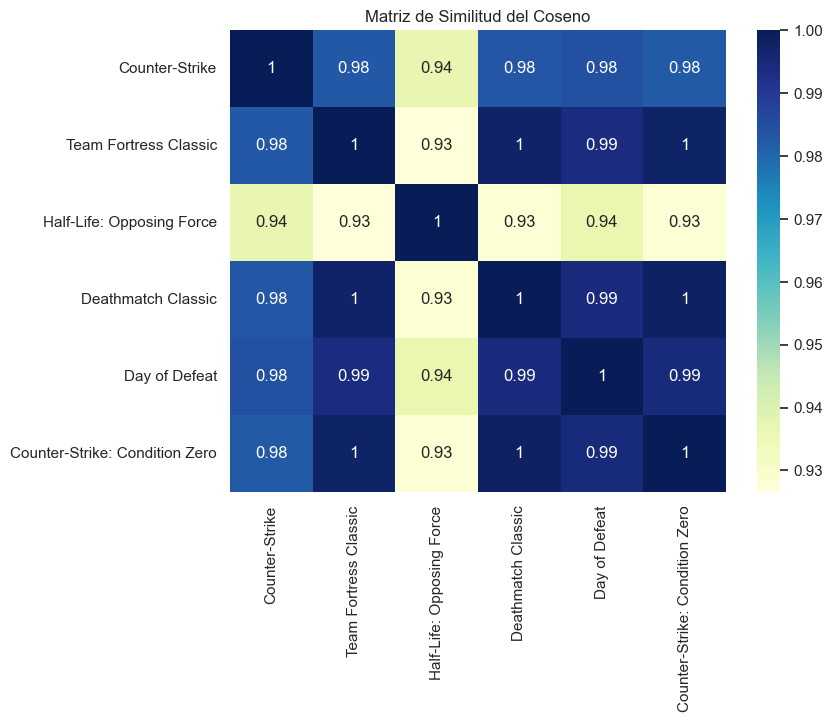

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ejemplo de uso para calcular la similitud entre más de dos elementos
similarity_matrix = calcular_similitud_coseno(juegos)

# Crear un heatmap para visualizar la matriz de similitud
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
sns.heatmap(similarity_matrix, annot=True, xticklabels=juegos, yticklabels=juegos, cmap="YlGnBu")
plt.title("Matriz de Similitud del Coseno")
plt.show()